# 1. Preparation

## 1.1. Import Libraries

In [51]:
import warnings

import lightgbm as lgb
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.utils.class_weight import compute_class_weight as ccw

from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    LeakyReLU,
    MaxPooling2D,
    Rescaling,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, to_categorical
from transformers import (
    RobertaTokenizer,
    TFRobertaModel,
)

warnings.simplefilter("ignore")

## 1.2. Fetching Data

In [2]:
seed = 0
np.random.seed(seed)
set_random_seed(seed)

train_df = pd.read_csv("../input/train.csv", index_col="text_id")
X_train = train_df.full_text
cols = [col for col in train_df.columns if col != "full_text"]
y_train = train_df[cols]
X_test = pd.read_csv("../input/test.csv", index_col="text_id").full_text
X_test_idx = X_test.index

## 1.3. Sentence Encodings

### 1.3.0. Custom Functions

In [3]:
def bert_encoder(texts, tokenizer, max_len):
    input_ids = []; attention_mask = []
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True, return_attention_mask=True)
        input_ids.append(token['input_ids'])
        attention_mask.append(token['attention_mask'])    
    return np.array(input_ids), np.array(attention_mask)

def train_test_split_scratch(X, y, test_size=.1):
    all_num = X[0].shape[0]
    test_num = int(all_num * (test_size))
    test_idx = np.random.choice(all_num, test_num, replace=False)
    train_idx = np.setdiff1d(np.arange(all_num), test_idx)
    return (X[0][train_idx], X[1][train_idx]), (X[0][test_idx], X[1][test_idx]), y.iloc[train_idx], y.iloc[test_idx]

reshape_func = lambda df: df.reshape(list(df.shape)+[1])

### 1.3.1. TFIDF with PCA

In [4]:
tokenizer_tfidf = Tokenizer()
tokenizer_tfidf.fit_on_texts(X_train)
X_train_tfidf = tokenizer_tfidf.texts_to_matrix(X_train, "tfidf")
X_test_tfidf = tokenizer_tfidf.texts_to_matrix(X_test, "tfidf")

pca_tfidf = PCA(n_components=500, whiten=True, random_state=seed)
X_train_tfidf = pca_tfidf.fit_transform(X_train_tfidf)
X_test_tfidf = pca_tfidf.transform(X_test_tfidf)

X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = tts(X_train_tfidf, y_train, test_size=.1, random_state=seed)

lgb_trains_tfidf = {}
lgb_vals_tfidf = {}
for col in cols:
    exec(f"lgb_trains_tfidf['{col}'] = lgb.Dataset(X_train_tfidf, y_train_tfidf.{col})")
    exec(f"lgb_vals_tfidf['{col}'] = lgb.Dataset(X_val_tfidf, y_val_tfidf.{col})")

### 1.3.2. roberta-base

In [5]:
max_len = 128 #512
roberta_dir = "roberta-base"#'../input/roberta-base/'

tokenizer_roberta = RobertaTokenizer.from_pretrained(roberta_dir)
model_roberta = TFRobertaModel.from_pretrained(roberta_dir)

X_train_roberta = bert_encoder(X_train, tokenizer_roberta, max_len)
X_test_roberta = bert_encoder(X_test, tokenizer_roberta, max_len)
X_train_roberta, X_val_roberta, y_train_roberta, y_val_roberta = train_test_split_scratch(X_train_roberta, y_train)

input_ids_roberta  = Input(shape=(X_train_roberta[0].shape[1], ), dtype = tf.int32)
attention_mask_roberta = Input(shape=(X_train_roberta[1].shape[1], ), dtype = tf.int32)
roberta_ = model_roberta(input_ids = input_ids_roberta, attention_mask = attention_mask_roberta)
roberta_ = Model(inputs = [input_ids_roberta, attention_mask_roberta], outputs = roberta_)
roberta_.compile(loss="rmse", optimizer="rmsprop")
X_train_roberta_3d = reshape_func(roberta_.predict(X_train_roberta).last_hidden_state)
X_val_roberta_3d = reshape_func(roberta_.predict(X_val_roberta).last_hidden_state)
X_test_roberta_3d = reshape_func(roberta_.predict(X_test_roberta).last_hidden_state)

pca_roberta = PCA(n_components=2000, whiten=True, random_state=seed)
X_train_roberta_pca = pca_roberta.fit_transform(X_train_roberta_3d.reshape((X_train_roberta_3d.shape[0], -1)))
X_val_roberta_pca = pca_roberta.transform(X_val_roberta_3d.reshape((X_val_roberta_3d.shape[0], -1)))
X_test_roberta_pca = pca_roberta.transform(X_test_roberta_3d.reshape((X_test_roberta_3d.shape[0], -1)))

lgb_trains_roberta = {}
lgb_vals_roberta = {}
for col in cols:
    exec(f"lgb_trains_roberta['{col}'] = lgb.Dataset(X_train_roberta_pca, y_train_roberta.{col})")
    exec(f"lgb_vals_roberta['{col}'] = lgb.Dataset(X_val_roberta_pca, y_val_roberta.{col})")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


1/1 [==============================] - 0s 67ms/step


(3911, 22170)
120


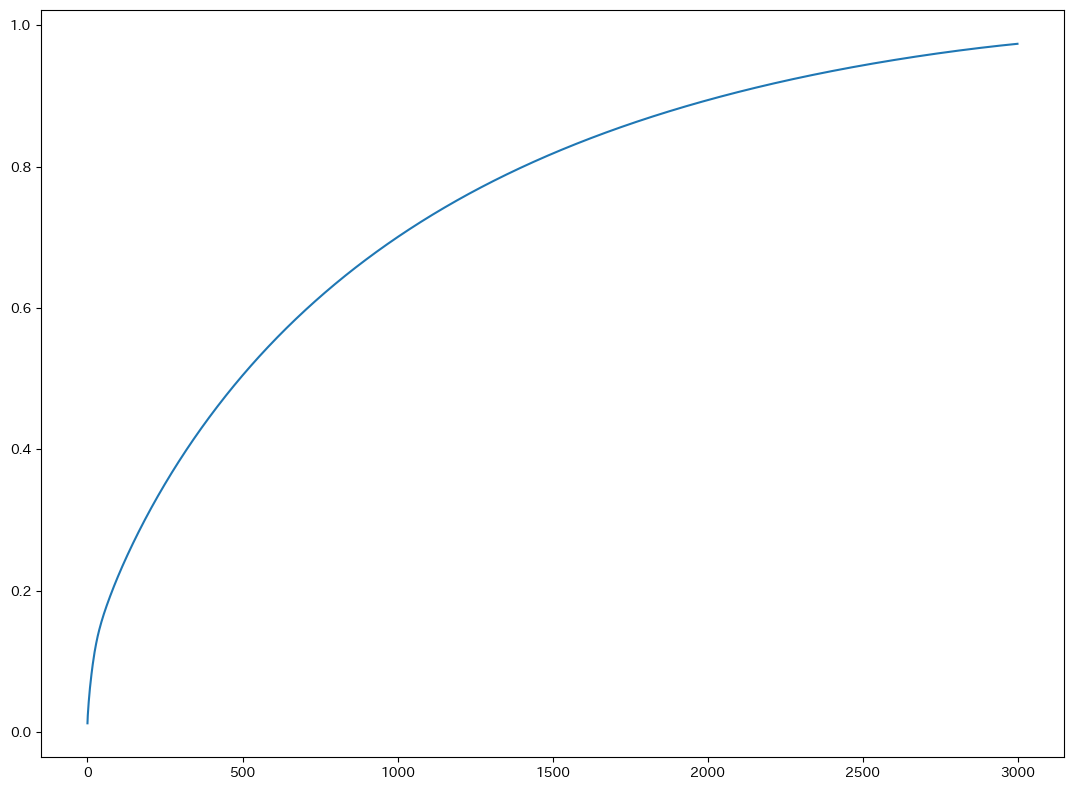

CPU times: user 16min 39s, sys: 7min 5s, total: 23min 45s
Wall time: 52.8 s


In [65]:
%%time

tokenizer_tfidf = Tokenizer()
tokenizer_tfidf.fit_on_texts(X_train)
X_train_tfidf = tokenizer_tfidf.texts_to_matrix(X_train, "tfidf")
print(X_train_tfidf.shape)

pca_tfidf = PCA(n_components=3000, whiten=True, random_state=seed)
print(pca_tfidf.fit_transform(X_train_tfidf).__sizeof__())

plt.plot(np.cumsum(pca_tfidf.explained_variance_ratio_))
plt.show()

(3911, 22170)
93864120


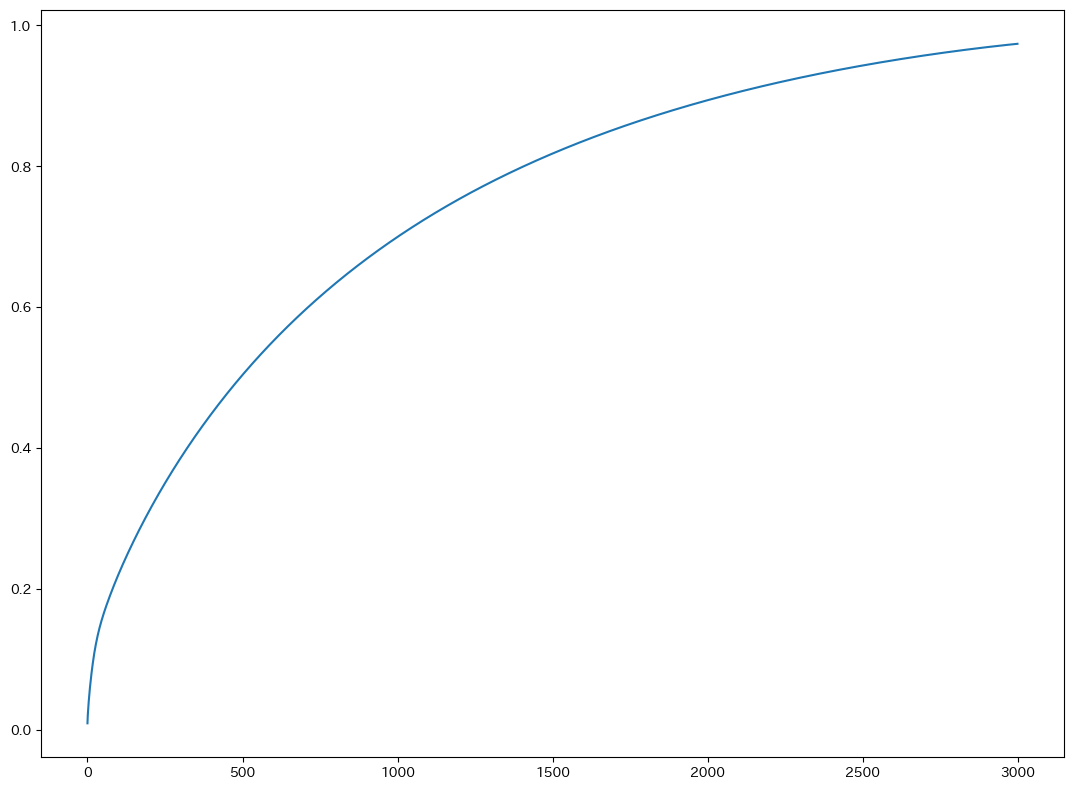

CPU times: user 20min 35s, sys: 7min 51s, total: 28min 26s
Wall time: 58.6 s


In [66]:
%%time

print(X_train_tfidf.shape)

svd_tfidf = TruncatedSVD(n_components=3000, random_state=seed)
print(svd_tfidf.fit_transform(X_train_tfidf).__sizeof__())

plt.plot(np.cumsum(svd_tfidf.explained_variance_ratio_))
plt.show()

120


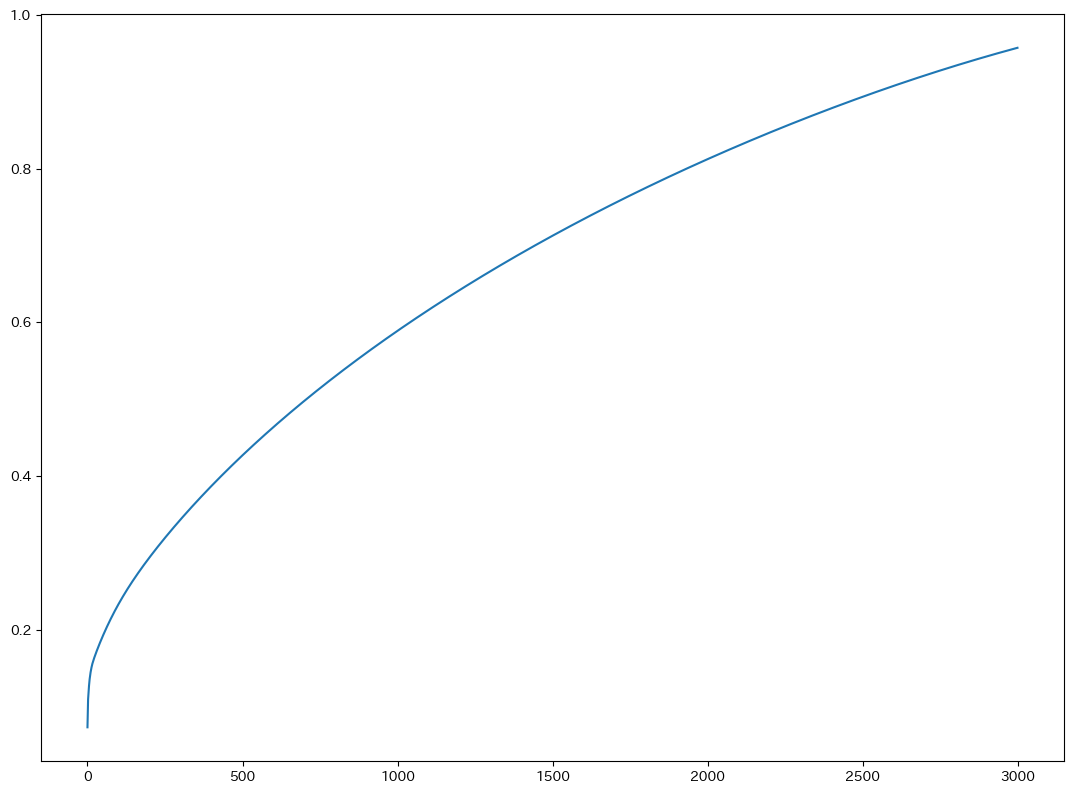

CPU times: user 38min 38s, sys: 32min 10s, total: 1h 10min 49s
Wall time: 2min 41s


In [69]:
%%time
pca_roberta = PCA(n_components=3000, random_state=seed)
check = pca_roberta.fit_transform(X_train_roberta_3d.reshape((X_train_roberta_3d.shape[0],-1)))
check.shape
print(check.__sizeof__())

import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca_roberta.explained_variance_ratio_))
plt.show()

42240120


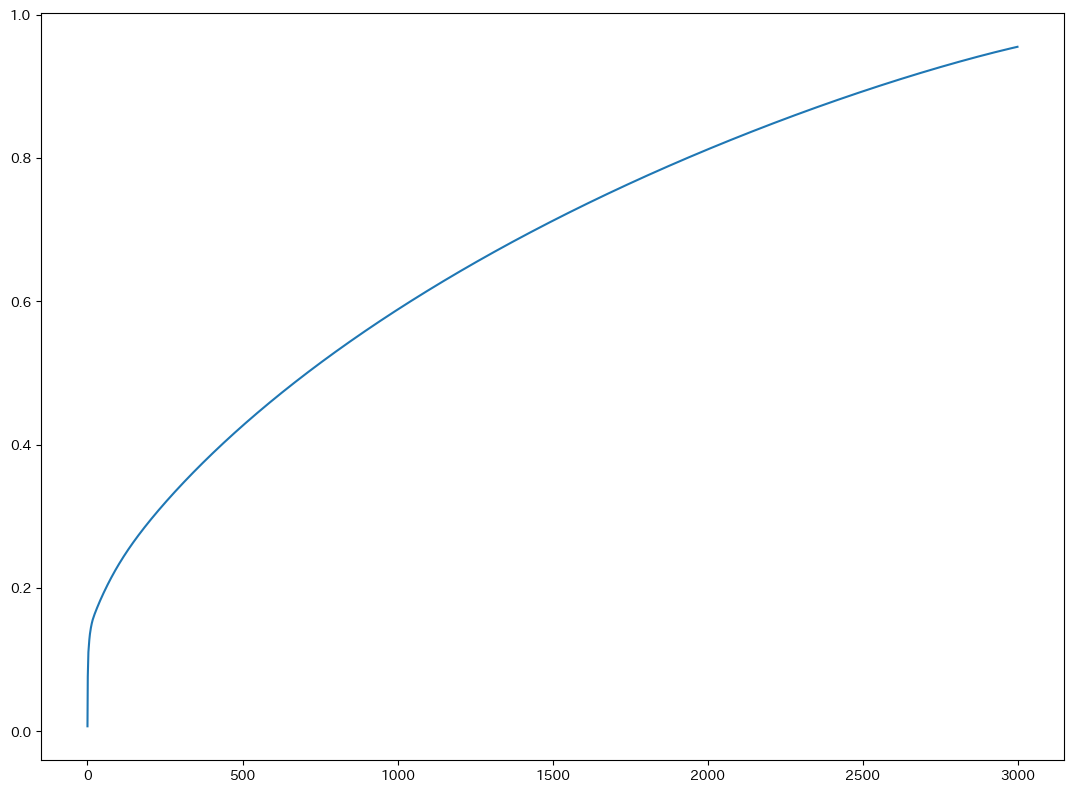

CPU times: user 1h 20min 58s, sys: 31min 43s, total: 1h 52min 41s
Wall time: 4min 36s


In [70]:
%%time
from sklearn.decomposition import TruncatedSVD
svd_roberta = TruncatedSVD(n_components=3000, random_state=seed)
check2 = svd_roberta.fit_transform(X_train_roberta_3d.reshape((X_train_roberta_3d.shape[0],-1)))
check2.shape
print(check2.__sizeof__())

plt.plot(np.cumsum(svd_roberta.explained_variance_ratio_))
plt.show()

# 2. Building Models

## 2.0. Custom Loss Functions

In [6]:
@tf.autograph.experimental.do_not_convert
def MCRMSE_keras(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))

def MCRMSE_lgb(preds, eval_data):
    diff = eval_data - preds
    sq = np.square(diff)
    rmse = np.sum(sq, axis=0) / eval_data.shape[0]
    return "MCRMSE", np.sum(rmse) / eval_data.shape[1], False

## 2.1. keras1: small Keras Model with tfidf-encoding

In [7]:
keras1_model = Sequential()
keras1_model.add(Dense(500, input_dim=X_train_tfidf.shape[1], activation="relu"))
keras1_model.add(BatchNormalization())
keras1_model.add(Dense(500, activation="relu"))
keras1_model.add(Dropout(.5))
keras1_model.add(Dense(500, activation="relu"))
keras1_model.add(Dropout(.5))
keras1_model.add(Dense(200, activation="relu"))
keras1_model.add(Dense(y_train.shape[1], activation="sigmoid"))
keras1_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras1_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
keras1_model.fit(X_train_tfidf, y_train_tfidf, batch_size=2**3, epochs=100, verbose=1,
          validation_data=(X_val_tfidf, y_val_tfidf), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras1_pred = pd.DataFrame(keras1_model.predict(X_test_tfidf), columns=cols, index=X_test_idx)
keras1_pred

Epoch 1/100
440/440 [==============================] - 4s 7ms/step - loss: 0.4869 - MCRMSE_keras: 0.4870 - val_loss: 0.3647 - val_MCRMSE_keras: 0.3647
Epoch 2/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3385 - MCRMSE_keras: 0.3385 - val_loss: 0.3429 - val_MCRMSE_keras: 0.3429
Epoch 3/100
440/440 [==============================] - 3s 7ms/step - loss: 0.2711 - MCRMSE_keras: 0.2711 - val_loss: 0.3458 - val_MCRMSE_keras: 0.3458
Epoch 4/100
440/440 [==============================] - 3s 8ms/step - loss: 0.2454 - MCRMSE_keras: 0.2454 - val_loss: 0.3529 - val_MCRMSE_keras: 0.3529
Epoch 5/100
440/440 [==============================] - 3s 8ms/step - loss: 0.2251 - MCRMSE_keras: 0.2251 - val_loss: 0.3534 - val_MCRMSE_keras: 0.3534
Epoch 6/100
440/440 [==============================] - 3s 7ms/step - loss: 0.2012 - MCRMSE_keras: 0.2012 - val_loss: 0.3473 - val_MCRMSE_keras: 0.3473
Epoch 7/100
440/440 [==============================] - 3s 7ms/step - loss: 0.1964 - MCRMSE_ker

1/1 [==============================] - 0s 92ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.804770,2.728215,2.989167,2.783143,2.682304,2.777767
000BAD50D026,2.757102,2.702014,2.941860,2.743857,2.671812,2.757508
00367BB2546B,3.494375,3.400168,3.596958,3.525245,3.406241,3.475540


In [7]:
keras1_model = Sequential()
keras1_model.add(Dense(500, input_dim=X_train_tfidf.shape[1], activation="relu"))
keras1_model.add(BatchNormalization())
keras1_model.add(Dense(500, activation="relu"))
keras1_model.add(Dropout(.3))
keras1_model.add(Dense(500, activation=LeakyReLU(.1)))
keras1_model.add(Dropout(.2))
keras1_model.add(Dense(500, activation="relu"))
keras1_model.add(Dense(y_train.shape[1], activation="sigmoid"))
keras1_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras1_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
keras1_model.fit(X_train_tfidf, y_train_tfidf, batch_size=2**3, epochs=30, verbose=1,
          validation_data=(X_val_tfidf, y_val_tfidf), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras1_pred = pd.DataFrame(keras1_model.predict(X_test_tfidf), columns=cols, index=X_test_idx)
keras1_pred

Epoch 1/30
440/440 [==============================] - 3s 5ms/step - loss: 0.3869 - MCRMSE_keras: 0.3870 - val_loss: 0.3311 - val_MCRMSE_keras: 0.3311
Epoch 2/30
440/440 [==============================] - 2s 4ms/step - loss: 0.3091 - MCRMSE_keras: 0.3092 - val_loss: 0.3334 - val_MCRMSE_keras: 0.3334
Epoch 3/30
440/440 [==============================] - 2s 4ms/step - loss: 0.2856 - MCRMSE_keras: 0.2856 - val_loss: 0.3280 - val_MCRMSE_keras: 0.3280
Epoch 4/30
440/440 [==============================] - 2s 4ms/step - loss: 0.2658 - MCRMSE_keras: 0.2658 - val_loss: 0.3211 - val_MCRMSE_keras: 0.3211
Epoch 5/30
440/440 [==============================] - 2s 4ms/step - loss: 0.2503 - MCRMSE_keras: 0.2503 - val_loss: 0.3317 - val_MCRMSE_keras: 0.3317
Epoch 6/30
440/440 [==============================] - 2s 4ms/step - loss: 0.2389 - MCRMSE_keras: 0.2389 - val_loss: 0.3424 - val_MCRMSE_keras: 0.3424
Epoch 7/30
440/440 [==============================] - 2s 4ms/step - loss: 0.2285 - MCRMSE_keras: 0.2

1/1 [==============================] - 0s 80ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.963785,2.769119,2.991218,2.912914,2.738309,2.812911
000BAD50D026,2.947985,2.858868,2.971609,2.895396,2.806762,2.909150
00367BB2546B,3.620040,3.479509,3.510632,3.619158,3.427733,3.479627


## 2.2. keras2: large Keras Model with tfidf-encoding

In [9]:
keras2_model = Sequential()
keras2_model.add(Dense(2000, input_dim=X_train_tfidf.shape[1], activation="relu"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(2000, activation="relu"))
keras2_model.add(Dropout(.3))
keras2_model.add(Dense(3000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.2))
keras2_model.add(Dense(2000, activation="relu"))
keras2_model.add(Dense(500, activation="relu"))
keras2_model.add(Dense(3000, activation="softplus"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(1000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.3))
keras2_model.add(Dense(3000, activation="softsign"))
keras2_model.add(Dense(1000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.1))
keras2_model.add(Dense(3000, activation="softplus"))
keras2_model.add(Dropout(.4))
keras2_model.add(Dense(3000, activation="relu"))
keras2_model.add(Dense(1000, activation="relu"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(y_train.shape[1], activation="sigmoid"))
keras2_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras2_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
keras2_model.fit(X_train_tfidf, y_train_tfidf, batch_size=2**3, epochs=50, verbose=1,
          validation_data=(X_val_tfidf, y_val_tfidf), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras2_pred = pd.DataFrame(keras2_model.predict(X_test_tfidf), columns=cols, index=X_test_idx)
keras2_pred

Epoch 1/50
440/440 [==============================] - 7s 14ms/step - loss: 0.4874 - MCRMSE_keras: 0.4875 - val_loss: 0.6546 - val_MCRMSE_keras: 0.6546
Epoch 2/50
440/440 [==============================] - 6s 13ms/step - loss: 0.4029 - MCRMSE_keras: 0.4029 - val_loss: 0.6405 - val_MCRMSE_keras: 0.6405
Epoch 3/50
440/440 [==============================] - 6s 13ms/step - loss: 0.3731 - MCRMSE_keras: 0.3730 - val_loss: 1.9810 - val_MCRMSE_keras: 1.9810
Epoch 4/50
440/440 [==============================] - 6s 13ms/step - loss: 0.3452 - MCRMSE_keras: 0.3452 - val_loss: 0.3921 - val_MCRMSE_keras: 0.3921
Epoch 5/50
440/440 [==============================] - 6s 13ms/step - loss: 0.3255 - MCRMSE_keras: 0.3255 - val_loss: 0.4325 - val_MCRMSE_keras: 0.4325
Epoch 6/50
440/440 [==============================] - 6s 13ms/step - loss: 0.2944 - MCRMSE_keras: 0.2944 - val_loss: 0.3670 - val_MCRMSE_keras: 0.3670
Epoch 7/50
440/440 [==============================] - 6s 13ms/step - loss: 0.2840 - MCRMSE_ker

1/1 [==============================] - 0s 176ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.805748,2.679327,3.033418,2.752163,2.636959,2.840636
000BAD50D026,2.709807,2.579508,2.968937,2.654088,2.518137,2.767656
00367BB2546B,3.627219,3.607767,3.658159,3.617604,3.686137,3.460452


In [8]:
keras2_model = Sequential()
keras2_model.add(Dense(2000, input_dim=X_train_tfidf.shape[1], activation="relu"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(2000, activation="relu"))
keras2_model.add(Dropout(.3))
keras2_model.add(Dense(3000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.2))
keras2_model.add(Dense(2000, activation="relu"))
keras2_model.add(Dense(500, activation="relu"))
keras2_model.add(Dense(3000, activation="softplus"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(1000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.3))
keras2_model.add(Dense(3000, activation="softsign"))
keras2_model.add(Dense(1000, activation=LeakyReLU(.1)))
keras2_model.add(Dropout(.1))
keras2_model.add(Dense(3000, activation="softplus"))
keras2_model.add(Dropout(.4))
keras2_model.add(Dense(3000, activation="relu"))
keras2_model.add(Dense(1000, activation="relu"))
keras2_model.add(BatchNormalization())
keras2_model.add(Dense(y_train.shape[1], activation="sigmoid"))
keras2_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras2_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
keras2_model.fit(X_train_tfidf, y_train_tfidf, batch_size=2**3, epochs=50, verbose=1,
          validation_data=(X_val_tfidf, y_val_tfidf), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras2_pred = pd.DataFrame(keras2_model.predict(X_test_tfidf), columns=cols, index=X_test_idx)
keras2_pred

Epoch 1/50
440/440 [==============================] - 6s 11ms/step - loss: 0.4854 - MCRMSE_keras: 0.4855 - val_loss: 0.3736 - val_MCRMSE_keras: 0.3736
Epoch 2/50
440/440 [==============================] - 5s 11ms/step - loss: 0.3818 - MCRMSE_keras: 0.3819 - val_loss: 0.4495 - val_MCRMSE_keras: 0.4495
Epoch 3/50
440/440 [==============================] - 5s 11ms/step - loss: 0.3867 - MCRMSE_keras: 0.3867 - val_loss: 0.3983 - val_MCRMSE_keras: 0.3983
Epoch 4/50
440/440 [==============================] - 5s 11ms/step - loss: 0.3636 - MCRMSE_keras: 0.3636 - val_loss: 0.3594 - val_MCRMSE_keras: 0.3594
Epoch 5/50
440/440 [==============================] - 5s 11ms/step - loss: 0.3587 - MCRMSE_keras: 0.3586 - val_loss: 0.3882 - val_MCRMSE_keras: 0.3882
Epoch 6/50
440/440 [==============================] - 4s 10ms/step - loss: 0.3864 - MCRMSE_keras: 0.3864 - val_loss: 0.4725 - val_MCRMSE_keras: 0.4725
Epoch 7/50
440/440 [==============================] - 5s 11ms/step - loss: 0.3699 - MCRMSE_ker

1/1 [==============================] - 0s 162ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.989588,2.980597,3.171119,3.033654,2.925820,2.951505
000BAD50D026,2.907359,2.897914,3.104528,2.943808,2.834405,2.868799
00367BB2546B,3.439269,3.368748,3.525527,3.531998,3.427338,3.441388


## 2.3. keras3: small Keras Model with roberta-encoding (2d input)

In [94]:
keras3_model = Sequential()
keras3_model.add(Dense(500, input_dim=X_train_roberta_pca.shape[1],  activation="relu"))
keras3_model.add(Dense(1000, activation="relu"))
keras3_model.add(Dropout(.5))
keras3_model.add(Dense(500, activation="relu"))
keras3_model.add(Dense(y_train_roberta.shape[1], activation="sigmoid"))
keras3_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras3_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])

keras3_model.fit(X_train_roberta_pca, y_train_roberta, batch_size=2**3, epochs=30, verbose=1,
          validation_data=(X_val_roberta_pca, y_val_roberta), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras3_pred = pd.DataFrame(keras3_model.predict(X_test_roberta_pca), columns=cols, index=X_test_idx)
keras3_pred

Epoch 1/30
440/440 [==============================] - 2s 3ms/step - loss: 0.4955 - MCRMSE_keras: 0.4955 - val_loss: 0.4131 - val_MCRMSE_keras: 0.4129
Epoch 2/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2854 - MCRMSE_keras: 0.2854 - val_loss: 0.2856 - val_MCRMSE_keras: 0.2854
Epoch 3/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2196 - MCRMSE_keras: 0.2196 - val_loss: 0.3135 - val_MCRMSE_keras: 0.3133
Epoch 4/30
440/440 [==============================] - 1s 3ms/step - loss: 0.1394 - MCRMSE_keras: 0.1394 - val_loss: 0.3025 - val_MCRMSE_keras: 0.3022
Epoch 5/30
440/440 [==============================] - 2s 4ms/step - loss: 0.1174 - MCRMSE_keras: 0.1174 - val_loss: 0.2965 - val_MCRMSE_keras: 0.2963
Epoch 6/30
440/440 [==============================] - 2s 4ms/step - loss: 0.0956 - MCRMSE_keras: 0.0956 - val_loss: 0.2983 - val_MCRMSE_keras: 0.2981
Epoch 7/30
440/440 [==============================] - 2s 4ms/step - loss: 0.0795 - MCRMSE_keras: 0.0

1/1 [==============================] - 0s 61ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.752523,2.717053,2.872118,2.760310,2.689044,2.745223
000BAD50D026,2.699581,2.544492,2.775638,2.642119,2.537196,2.584038
00367BB2546B,3.698744,3.682313,3.622563,3.659604,3.627332,3.645622


## 2.4. keras4: small CNN Keras Model with roberta-encoding (3d input)

In [10]:
keras4_model = Sequential()
keras4_model.add(BatchNormalization())
keras4_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train_roberta_3d.shape[1:]))
keras4_model.add(MaxPooling2D((2, 2)))
keras4_model.add(Conv2D(64, (3, 3), activation='relu'))
keras4_model.add(MaxPooling2D((2, 2)))
keras4_model.add(Conv2D(64, (3, 3), activation='relu'))
keras4_model.add(Flatten())
keras4_model.add(BatchNormalization())
keras4_model.add(Dense(500,  activation="relu"))
keras4_model.add(Dense(1000, activation="relu"))
keras4_model.add(Dropout(.1))
keras4_model.add(Dense(500, activation="relu"))
keras4_model.add(Dense(y_train_roberta.shape[1], activation="linear"))
#keras4_model.add(Rescaling(4, offset=1))z

optimizer = optimizers.Adam(amsgrad=True)
keras4_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])

keras4_model.fit(X_train_roberta_3d, y_train_roberta, batch_size=2**3, epochs=30, verbose=1,
          validation_data=(X_val_roberta_3d, y_val_roberta), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras4_pred = pd.DataFrame(keras4_model.predict(X_test_roberta_3d), columns=cols, index=X_test_idx)
keras4_pred

Epoch 1/30
440/440 [==============================] - 63s 137ms/step - loss: 127.9664 - MCRMSE_keras: 127.9664 - val_loss: 0.7688 - val_MCRMSE_keras: 0.7682
Epoch 2/30
440/440 [==============================] - 56s 127ms/step - loss: 0.3792 - MCRMSE_keras: 0.3792 - val_loss: 1.1548 - val_MCRMSE_keras: 1.1543
Epoch 3/30
440/440 [==============================] - 56s 127ms/step - loss: 0.3358 - MCRMSE_keras: 0.3358 - val_loss: 1.6506 - val_MCRMSE_keras: 1.6498
Epoch 4/30
440/440 [==============================] - 56s 128ms/step - loss: 0.3219 - MCRMSE_keras: 0.3219 - val_loss: 1.4516 - val_MCRMSE_keras: 1.4509
Epoch 5/30
440/440 [==============================] - 58s 131ms/step - loss: 0.2591 - MCRMSE_keras: 0.2591 - val_loss: 0.3834 - val_MCRMSE_keras: 0.3835
Epoch 6/30
440/440 [==============================] - 56s 127ms/step - loss: 0.2129 - MCRMSE_keras: 0.2129 - val_loss: 0.5669 - val_MCRMSE_keras: 0.5674
Epoch 7/30
440/440 [==============================] - 56s 127ms/step - loss: 0

1/1 [==============================] - 0s 200ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.643941,2.785937,3.085424,2.716612,2.739584,2.518022
000BAD50D026,2.747708,2.415225,2.662930,2.298503,2.178475,2.592122
00367BB2546B,2.817374,2.855446,3.147187,2.696755,2.697556,2.833001


## 2.5. keras5: small Keras Model with roberta-encoding (2d input - 1 choosed layer)

In [9]:
keras5_target = 1

keras5_model = Sequential()
keras5_model.add(Dense(500, input_dim=X_train_roberta_3d[:,keras5_target,:,0].shape[1],  activation="relu"))
keras5_model.add(Dense(1000, activation="relu"))
keras5_model.add(Dropout(.5))
keras5_model.add(Dense(500, activation="relu"))
keras5_model.add(Dense(y_train_roberta.shape[1], activation="sigmoid"))
keras5_model.add(Rescaling(4, offset=1))

optimizer = optimizers.Adam(amsgrad=True)
keras5_model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])

keras5_model.fit(X_train_roberta_3d[:,keras5_target,:,0], y_train_roberta, batch_size=2**3, epochs=30, verbose=1,
          validation_data=(X_val_roberta_3d[:,keras5_target,:,0], y_val_roberta), workers=30, use_multiprocessing=True,
          callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

keras5_pred = pd.DataFrame(keras5_model.predict(X_test_roberta_3d[:,keras5_target,:,0]), columns=cols, index=X_test_idx)
keras5_pred

Epoch 1/30
440/440 [==============================] - 2s 3ms/step - loss: 0.3733 - MCRMSE_keras: 0.3733 - val_loss: 0.3298 - val_MCRMSE_keras: 0.3295
Epoch 2/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2992 - MCRMSE_keras: 0.2992 - val_loss: 0.3258 - val_MCRMSE_keras: 0.3256
Epoch 3/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2799 - MCRMSE_keras: 0.2799 - val_loss: 0.3284 - val_MCRMSE_keras: 0.3280
Epoch 4/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2623 - MCRMSE_keras: 0.2623 - val_loss: 0.3257 - val_MCRMSE_keras: 0.3253
Epoch 5/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2487 - MCRMSE_keras: 0.2487 - val_loss: 0.3263 - val_MCRMSE_keras: 0.3260
Epoch 6/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2422 - MCRMSE_keras: 0.2422 - val_loss: 0.3123 - val_MCRMSE_keras: 0.3120
Epoch 7/30
440/440 [==============================] - 1s 3ms/step - loss: 0.2275 - MCRMSE_keras: 0.2

1/1 [==============================] - 0s 62ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.647943,2.580876,2.835324,2.696351,2.637722,2.527094
000BAD50D026,3.129585,2.991297,3.167293,3.060746,2.941916,3.096443
00367BB2546B,3.276878,3.265459,3.469006,3.352366,3.356730,3.336330


## 2.4. lgb1: LightGBM Model with tfidf-encoding

In [11]:
lgb1_models = {}
lgb1_preds = {}

for score in cols:
    lgb1_params = {'objective': 'regression',
                   'metric': 'rmse',
                   'verbosity': 0,
                   'early_stopping_round': 50,
                   'random_state': seed,
                   'device': 'gpu'}
    
    train_set=lgb_trains_tfidf[score]
    valid_sets=lgb_vals_tfidf[score]

    lgb1_model = lgb.train(
        params=lgb1_params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=(train_set, valid_sets),
        callbacks=None,
        verbose_eval=100
    )
    
    lgb1_models[score] = lgb1_model
    lgb1_preds[score] = lgb1_model.predict(X_test_tfidf)
    
lgb1_pred = pd.DataFrame(lgb1_preds, index=X_test_idx)
lgb1_pred

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.229601	valid_1's rmse: 0.604514
Early stopping, best iteration is:
[58]	training's rmse: 0.323036	valid_1's rmse: 0.598864
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.228208	valid_1's rmse: 0.555162
Early stopping, best iteration is:
[71]	training's rmse: 0.286076	valid_1's rmse: 0.548377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's rmse: 0.322176	valid_1's rmse: 0.498272
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.229137	valid_1's rmse: 0.556103
Early stopping, best iteration is:
[72]	training's rmse: 0.283216	valid_1's rmse: 0.552301
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.249628	valid_1's rmse: 0.618536
Early stopping, best iteration is:
[58]	training's rmse: 0.346478	valid_1's rmse: 0.612825
Training unt

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,3.019085,2.909469,3.166960,2.825631,2.714723,2.622996
000BAD50D026,3.219392,2.851266,3.033757,3.006670,2.572265,3.079148
00367BB2546B,3.773325,3.421739,3.666559,3.480376,3.541353,3.499535


## 2.5. lgb2: LightGBM Model with roberta_ids

In [ ]:
lgb2_models = {}
lgb2_preds = {}

for score in cols:
    lgb2_params = {'objective': 'regression',
                   'metric': 'rmse',
                   'verbosity': 0,
                   'early_stopping_round': 50,
                   'random_state': seed,
                   'device': 'gpu'}
    
    train_set=lgb_trains_roberta[score]
    valid_sets=lgb_vals_roberta[score]

    lgb2_model = lgb.train(
        params=lgb2_params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=(train_set, valid_sets),
        callbacks=None,
        verbose_eval=100
    )
    
    lgb2_models[score] = lgb2_model
    lgb2_preds[score] = lgb2_model.predict(X_test_roberta_3d[:,1,:,0])
    
lgb2_pred = pd.DataFrame(lgb2_preds, index=X_test_idx)
lgb2_pred

## 2.5. lgb3: LightGBM Model with roberta-encoding

In [6]:
lgb3_models = {}
lgb3_preds = {}

for score in cols:
    lgb3_params = {'objective': 'regression',
                   'metric': 'rmse',
                   'verbosity': 0,
                   'early_stopping_round': 50,
                   'random_state': seed,
                   'device': 'gpu'}
    
    train_set=lgb_trains_roberta[score]
    valid_sets=lgb_vals_roberta[score]

    lgb3_model = lgb.train(
        params=lgb3_params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=(train_set, valid_sets),
        callbacks=None,
        verbose_eval=100
    )
    
    lgb3_models[score] = lgb3_model
    lgb3_preds[score] = lgb3_model.predict(X_test_roberta_pca)
    
lgb3_pred = pd.DataFrame(lgb3_preds, index=X_test_idx)
lgb3_pred

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's rmse: 0.335681	valid_1's rmse: 0.605719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's rmse: 0.334978	valid_1's rmse: 0.521349
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.114305	valid_1's rmse: 0.529278
Early stopping, best iteration is:
[57]	training's rmse: 0.212235	valid_1's rmse: 0.528903
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.127145	valid_1's rmse: 0.544383
Early stopping, best iteration is:
[55]	training's rmse: 0.242747	valid_1's rmse: 0.543852
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's rmse: 0.308323	valid_1's rmse: 0.596516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	training's rmse: 0.381359

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.955500,2.798980,3.170331,2.893913,2.706838,2.827876
000BAD50D026,2.698052,2.458195,2.779996,2.556159,2.439393,2.702144
00367BB2546B,3.192263,3.406182,3.712828,3.461215,3.423035,3.598236


## 2.5. lgb4: LightGBM Model with roberta-encoding Classification

In [91]:
lgb4_models = {}
lgb4_preds_argmax = {}
lgb4_preds_probability = {}

lgb_trains_roberta_cat = {}
lgb_vals_roberta_cat = {}

for col in cols:
    y_train_categorical = y_train_roberta[col]
    y_val_categorical = y_val_roberta[col]
    weight = dict(zip(np.array(range(2, 11, 1)) /2,
                      ccw(class_weight='balanced', classes=np.unique(y_train_categorical), y=y_train_categorical)))
    train_weight = [weight[i] for i in y_train_categorical]
    val_weight = [weight[i] for i in y_val_categorical]
    lgb_trains_roberta_cat[col] = lgb.Dataset(X_train_roberta_pca, y_train_categorical, free_raw_data=False, weight=train_weight)
    lgb_vals_roberta_cat[col] = lgb.Dataset(X_val_roberta_pca, y_val_categorical, free_raw_data=False, weight=val_weight)

for score in cols:
    lgb4_params = {'objective': 'multiclass',
                   'metric': 'multi_logloss',
                   'num_class': 9,
                   'num_leaves': 100,
                   'max_iter': 10000,
                   'verbosity': -1,
                   'early_stopping_round': 50,
                   'random_state': seed,
                   'device': 'gpu'}
    
    train_set=lgb_trains_roberta_cat[score]
    valid_sets=lgb_vals_roberta_cat[score]

    lgb4_model = lgb.train(
        params=lgb4_params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=(train_set, valid_sets),
        callbacks=None,
        verbose_eval=100
    )
    
    lgb4_models[score] = lgb4_model
    lgb4_preds_argmax[score] = lgb4_model.predict(X_test_roberta_pca)
    lgb4_preds_probability[score] = np.dot(lgb4_preds_argmax[score], np.array(list(weight.keys())))
    lgb4_preds_argmax[score] = [list(weight.keys())[i] for i in np.argmax(lgb4_preds_argmax[score] , axis=1)]
    
lgb4_pred_argmax = pd.DataFrame(lgb4_preds_argmax, index=X_test_idx)
lgb4_pred_argmax

lgb4_pred_probability = pd.DataFrame(lgb4_preds_probability, index=X_test_idx)
lgb4_pred_probability

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's multi_logloss: 0.785821	valid_1's multi_logloss: 1.58326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's multi_logloss: 0.665223	valid_1's multi_logloss: 1.41076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's multi_logloss: 1.05247	valid_1's multi_logloss: 1.5921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's multi_logloss: 0.773894	valid_1's multi_logloss: 1.42386
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's multi_logloss: 0.680759	valid_1's multi_logloss: 1.46841
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's multi_logloss: 0.907645	valid_1's multi_logloss: 1.

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.0,2.0,2.5,2.0,2.0,2.5
000BAD50D026,2.5,2.0,2.5,2.0,2.0,2.0
00367BB2546B,2.5,3.0,2.5,3.0,3.0,3.0


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.399561,2.296134,2.392576,2.272267,2.289611,2.365816
000BAD50D026,2.321107,2.240885,2.375593,2.341672,2.297098,2.339070
00367BB2546B,2.409786,2.498440,2.444131,2.537912,2.494004,2.595239


In [15]:
preds = [keras1_pred, keras2_pred, keras3_pred, keras4_pred, lgb1_pred, lgb2_pred]
pred = pd.DataFrame(np.mean(np.array(preds), axis=0), columns=cols, index=X_test_idx)
pred

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.767483,2.733454,2.969960,2.808294,2.716757,2.652545
000BAD50D026,3.038738,2.872625,3.037558,2.952971,2.719184,2.952540
00367BB2546B,3.365481,3.267979,3.486429,3.339178,3.286980,3.294214


In [86]:
pred.to_csv("submission.csv", index=True)